In [45]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [10]:
import torch
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.data.transforms import *
from fastai2.distributed import *

In [11]:
import fastai2

In [12]:
%matplotlib inline

In [13]:
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 170)
pd.set_option('display.max_colwidth', -1)

/home/auri/anaconda3/envs/fastai2/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [14]:
import numpy as np
from matplotlib import pyplot as plt
import openslide
from numpy import asarray

In [15]:
def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],[np.sin(angle),  np.cos(angle)]])
    o,p = np.atleast_2d(origin), np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

class TMA:
    diameter_spot = 1200
    def __init__(self, tma_path, file, img_path_tif):
        self.meta_fn = file
        self.meta_path = tma_path
        self.img_path_tif = img_path_tif
        self.name = file.strip('.txt')[len('TMA results - '):]
        #self.spots = None #self.load_spots_meta()
        #self.img_tif = None #self.load_img_tif()

    @property
    def img_tif(self):
        self.__img_tif = self.load_img_tif()
        return self.__img_tif
    
    @property
    def spots(self):
        self.__spots = self.load_spots_meta()
        return self.__spots
        
    def load_tma_meta(self):
        df1 = pd.read_csv(os.path.join(self.meta_path, self.meta_fn), names=['fn', 'missing','X', 'Y', 'ID'], sep='\t', skiprows=[0])
        return df1
    
    def load_img_tif(self):
        a = None
        try:
            a = openslide.OpenSlide(os.path.join(self.img_path_tif, self.name + '.tif'))
        except: 
            print(f"BAD {self.name}.tif")
        return a
    
    def load_spots_meta(self):
        spots = []
        for index, rows in self.load_tma_meta().iterrows():
            spots.append(Spot(self.diameter_spot, 
                              rows.fn, rows.missing, (rows.X, rows.Y), rows.ID,
                        self.meta_path, self))
        return spots


In [134]:
class Spot: 
    def __init__(self, diameter, name, missing, center, ID, img_path_jpg, tma):
        self.path_jpg = img_path_jpg
        self.diameter = diameter #in micrometers
        self.name = name
        self.center = center #in micrometers
        self.missing = missing
        self.ID = ID
        self.TMA = tma
        self.tiles = []
        
    def load_img_jpg(self):
        s = openslide.ImageSlide(os.path.join(self.path_jpg, self.name + '.jpg'))
        #regions to be read with method s.read_region()
        return s
    
    #get spot center coordinates in pixels
    def get_center_pixel(self):
        tma = self.TMA.img_tif
        c_x, c_y = self.center 
        mpp_x, mpp_y = float(tma.properties['openslide.mpp-x']), float(tma.properties['openslide.mpp-y']) #mpp  - 0.25  micras per pixel
        pc_x, pc_y = int(c_x / float(mpp_x)),int(c_y / float(mpp_y))
        return pc_x, pc_y
    
    #return radious in pixels both at full magnification (level = 0) and at a given zoom-out level
    def get_radious_pixel(self, level):
        tma = self.TMA.img_tif
        mpp_x, mpp_y = float(tma.properties['openslide.mpp-x']), float(tma.properties['openslide.mpp-y'])
        #mpp = (mpp_x**2 + mpp_y**2)**0.5
        pspot_radio = int(self.diameter/ mpp_x / 2 )
        pzoom_radio = int( pspot_radio/ 2**level ) #with each increasing level the image is reduced half size 
        return pspot_radio, pzoom_radio
    
    #return spot circunference's north and sud y-coordinates (absolute positions in level 0) 
    #given a relative position from 0 (left) to 1 (right) in the spot diameter in axis x
    def get_circle_coordinates_pixel(self, rel_pos_diameter_x = .5): #return by default the y-coordinates for x fixed at center
        pc_x, pc_y = self.get_center_pixel()
        pspot_radio, _ = self.get_radious_pixel(0)
        x = int(pc_x - pspot_radio + rel_pos_diameter_x*(pspot_radio*2))
        if (( x + pspot_radio < pc_x) or ( x - pspot_radio > pc_x)): #x should be in circle diameter (pc_x - pspot_radio, pc_x + pspot_radio)
            return x, np.nan, np.nan
        root = (pspot_radio**2 - (x - pc_x)**2)**0.5
        y_north = int( -root + pc_y)
        y_sud = int( root + pc_y)
        return x, y_north, y_sud
    
    #check (true or false) if there is scarce tissue in an image
    def check_scarce_tissue(self, tile_image): 
        s = asarray(tile_image)
        return s.mean() >= 230 #completely white = 255
    
    #return an image tile from the spot where x,y is the left-sup corner of the tile
    #for reference for current scanned tifs properties, level 0 is fully magnified image and for level 4 encloses one spot of diameter 1.2 micrometers
    def get_tile(self, x,y , size=(300,300) , level = 4, path = None, tif_name = None, degrees=0.):
        tma = None
        if (tif_name == None): tma = self.TMA.img_tif
        else:
            try:
                tma = openslide.OpenSlide(os.path.join(path, tif_name + '.tif'))
            except: 
                print(tif_name + '.tif')
                
        if degrees !=0:
            size_l0 = (size[0]*(2**level),size[1]*(2**level))
            corners = np.array([[x,y],[x+size_l0[0],y],[x+size_l0[0],y+size_l0[1]],[x,y+size_l0[1]]])
            rotated_corners = rotate(corners,np.array([[x+size_l0[0]/2,y+size_l0[1]/2]]),degrees)
            x0,y0=int(np.amin(rotated_corners[:,0])),int(np.amin(rotated_corners[:,1]))
            x1,y1=int(math.ceil(np.amax(rotated_corners[:,0]))),int(math.ceil(np.amax(rotated_corners[:,1])))
            rotated_size = int(math.ceil((x1-x0)/(2**level))),int(math.ceil((y1-y0)/(2**level)))
        else:
            rotated_size = size
        image = tma.read_region((x,y),level,rotated_size)
        if degrees != 0:
            y0,y1 = int(rotated_size[1]/2-size[1]/2),size[1]+int(rotated_size[1]/2-size[1]/2)
            x0,x1 = int(rotated_size[0]/2-size[0]/2),size[0]+int(rotated_size[0]/2-size[0]/2)
            rotated_image = Image.fromarray(ndimage.rotate(image, degrees, reshape=False)).crop((x0,y0,x1,y1))
            
            image = image.crop((x0,y0,x1,y1)) if Spot.check_scarce_tissue(Spot, rotated_image) else rotated_image

        #if Spot.check_scarce_tissue(Spot, image):
        #    return np.nan
        return image

   
        
    
    #check (true or false) that tile (defined by left sup coordinate and size in a zoom level) is enclosed in a box defined by the 4 spot poles 
    def check_tile_in_spot(self, x,y,size=(300,300) , level = 4):
        spot_poles = (self.get_circle_coordinates_pixel(0)[0], #left
                  self.get_circle_coordinates_pixel(1)[0],  #right
                  self.get_circle_coordinates_pixel(0.5)[1], #north
                  self.get_circle_coordinates_pixel(0.5)[2]) #sud
        if (x < spot_poles[0]) or (y < spot_poles[2] ) or (x + size[0]*(2**level) > spot_poles[1] ) or (y + size[1]*(2**level) > spot_poles[3]):
            return False, spot_poles
        else:
            return True, spot_poles
        
        
    #given a tile size in pixels and zoom level then sample all possible tiles from spot 
    #with a given overlap (0 to <1)
    #return all tiles (defined by sup-lef corner coordinates, size and level) 
    #enclosed in box-spot with enough tissue 
    def sample_tiles(self, size = (300,300), level = 4, overlap = .2):
        self.tiles = []
        pspot_radio, _ = self.get_radious_pixel(level)
        spot_tile_ratio = pspot_radio * 2 / size[0] 
        spot_tile_ratio_by_zoom = spot_tile_ratio / 2**level 
        stride_norm = 1 - overlap
        #print(np.arange(0,1,stride_norm/spot_tile_ratio_by_zoom))
        for i_x in np.arange(0,1,stride_norm/spot_tile_ratio_by_zoom): 
            x, y_north, y_sud = self.get_circle_coordinates_pixel(i_x)
            if (y_sud-y_north == 0): #intersection of ecuador with circunference
                if self.check_tile_in_spot(x, int(y_north), size, level)[0]:
                    self.tiles.append([x, int(y_north), size, level])
                if self.check_tile_in_spot(x, int(y_north), size, level)[0]:
                    self.tiles.append([x, int(y_north) - pspot_radio, size, level])
            else:
                for j in np.arange(y_north, y_sud, (y_sud-y_north)*stride_norm/spot_tile_ratio_by_zoom ): 
                    if self.check_tile_in_spot(x, int(j), size, level)[0]:
                        self.tiles.append([x, int(j), size, level])

        return self.tiles
    
    

    #given a zoom level it returns the box enclosing only this spot
    def get_enclosing_box(self, level, return_image = True):
        pspot_radio, pzoom_radio = self.get_radious_pixel(level)
        #print(pzoom_radio)
        pc_x, pc_y = self.get_center_pixel()
        x,y,size,level = pc_x - pspot_radio, pc_y - pspot_radio,  (pzoom_radio * 2, pzoom_radio * 2), level
        if return_image: 
            tile = self.get_tile(x,y,size,level )
        else: 
            tile = [x,y,size,level]
        return tile
    
    #given a tile defined by [x,y,size,zoom_level] return an enlarged tile 
    #the enlarged tile is defined as the minimal tile needed to enclose original tile rotated around the tile center by n_degrees (values 0 to 90º)
    #for default rotation (45º) the enlargement factor is hence equal to hypothenuse of a side of length 1 triangle (1/sin 45º = 2^(1/2))
    @staticmethod
    def enlarge_tile(x,y, original_tile_size = (300,300), level = 0, n_degrees = 45 ):
        #calculate the enlargement factor for rotation degrees
        enlargement_factor = np.sin(np.deg2rad(n_degrees + 45))/np.sin(np.deg2rad(45))
        #calculate half side length of original tile in pixels in level 0 (max zoom-in or pixels in source image)
        half_side_length = (2**level) * (original_tile_size[0]/ 2)  #it is assuming tile sizes are always square
        #calculate enlarged side length of new enclosing tile to include original tile rotated n degrees
        new_half_side_length = half_side_length * enlargement_factor
        #calculate new upper-left corner coordinate (new_half_side_lenghth need to be substracted because origin of image in pixels is always upper-left image corner)
        x_new,y_new = int(x + (half_side_length - new_half_side_length)), int(y + (half_side_length - new_half_side_length) )
        return [x_new,y_new,(int(original_tile_size[0] * enlargement_factor), int( original_tile_size[0] * enlargement_factor) ),level]
        
        

In [17]:
path = 'SPOTS/TMA06-03.qptma.data/'
#df = pd.read_csv('DTS2020 ALENDA.xlsx - DTS2020_ALENDA.csv', )
df = pd.read_excel('DTS2020 ALENDA.xlsx', )
df_labels = df[['COD_DTS','Epicolon1+2IHQ-IMS-maria paper lynlike_IMS','LynchIMS','ihq_mlh1','dukes_r',
 'TNMagrup','BaseEP1y2actualizada2016-OSCAR-def_n', 'grado_di','infirec','moc',
'edat', 'sexe','ccr_sin','aden_sin','r_beth_4',
'RECIMORT','KRAS','localizacion','fechreci','ILEact','estfseagrup']]



In [18]:
import os
tmas = []
for root, dirs, files in os.walk("SPOTS"):
    for file in files:
        if file.endswith(".txt") and re.search('TMA.*', file) :  #To process all tif files replace regex by .*
            tma = TMA(root, file, 'DTS2019')
            tmas.append(tma)
            

            

In [19]:
#generate Dataset 
ds = pd.DataFrame(columns=['tile', 'path','tif_fn', 'patient_ID','label'])
print(ds)

Empty DataFrame
Columns: [tile, path, tif_fn, patient_ID, label]
Index: []


In [20]:
def process_tma(tma,label = 'edat', level=3):
    ds = pd.DataFrame(columns=['tile', 'path','tif_fn', 'patient_ID','label'])
    for spot in tma.spots:
        tiles = [] 
        if (level >= 4): #level 4 is max zoom level out for each spot in TMAs provided
            tiles = [spot.get_enclosing_box(level, return_image = False)]
        else: 
            tiles = spot.sample_tiles(size = (300,300), level = level, overlap = .2)
        for tile in tiles:
            #only add tile if its generated image is valid 
            img = spot.get_tile(*tile)
            if isinstance(img, Image.Image): 
                s = df_labels.loc[df_labels['COD_DTS'] == str(spot.ID)]
                if (s.shape[0] != 0):
                    if label == 'edat':
                        l = float(str(s.iloc[0][label]).replace(',','.'))
                    else:
                        l = s.iloc[0][label]

                    if not np.isnan(l):
                        ds = ds.append({'tile': tile, 'path': tma.img_path_tif, 'tif_fn': tma.name, 'patient_ID': spot.ID,'label': l }, ignore_index=True)          
    
    return ds

In [21]:
 for t in tmas: print(t.name)

TMA06-03
TMA06-04
TMA06-05
TMA06-06
TMA06-07
TMA06-08
TMA06-09
TMA06-10
TMA06-12
TMA06-15
TMA08-15
TMA08-16
TMA08-17
TMA08-18
TMA08-33
TMA08-34
TMA08-36
TMA08-37
TMA08-38
TMA08-46
TMA08-68
TMA08-70
TMA08-72
TMA09-22
TMA09-37
TMA09-46
TMA14-04
TMA14-05
TMA14-06
TMA06-11
TMA08-35 (2)
TMA20-002
TMA20-003
TMA20-004
TMA20-005
TMA20-006
TMA20-009


In [22]:
def load_dataset(level = 0):
    lev = level
    try:
        p_ds = f'dataset_level_{lev}.csv'
        ds = pd.read_csv(p_ds)
        #ds = pd.concat([load_dataset(0)])
        ds['tile']=ds['tile'].apply(eval)
    except:
        print('failed')
        res = parallel(partial(process_tma,level = lev),tmas)
        ds = pd.concat((*res,))
        ds.to_csv(p_ds,index=False)
    return ds



In [128]:
ds = pd.concat([load_dataset(0), load_dataset(1), load_dataset(2), load_dataset(3), load_dataset(4)])
#ds = load_dataset(4)

/home/auri/anaconda3/envs/fastai2/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [135]:
ds['tile_rot_augmentation'] = ds.tile.apply(lambda x: Spot.enlarge_tile(*x))
ds.to_csv(f'dataset_level_all_June20.csv')


In [137]:
ds[['tile_rot_augmentation','tile']]

,tile_rot_augmentation,tile
0,"[13277, 6227, (424, 424), 0]","[13340, 6290, (300, 300), 0]"
1,"[13277, 6331, (424, 424), 0]","[13340, 6394, (300, 300), 0]"
2,"[13277, 6436, (424, 424), 0]","[13340, 6499, (300, 300), 0]"
3,"[13517, 5717, (424, 424), 0]","[13580, 5780, (300, 300), 0]"
4,"[13517, 5861, (424, 424), 0]","[13580, 5924, (300, 300), 0]"
...,...,...
1993,"[33205, 80205, (424, 424), 4]","[34200, 81200, (300, 300), 4]"
1994,"[41705, 79705, (424, 424), 4]","[42700, 80700, (300, 300), 4]"
1995,"[50105, 79305, (424, 424), 4]","[51100, 80300, (300, 300), 4]"
1996,"[58405, 79205, (424, 424), 4]","[59400, 80200, (300, 300), 4]"


1.4142135623730951


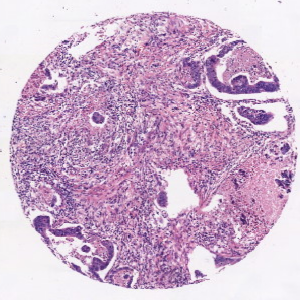

In [126]:
r =ds.iloc[1] 
enlarged_tile = Spot.enlarge_tile(*r.tile, n_degrees = 45)
Spot.get_tile(Spot, *(r.tile), path=r.path, tif_name = r.tif_fn)

[18449, 3423, (424, 424), 4]


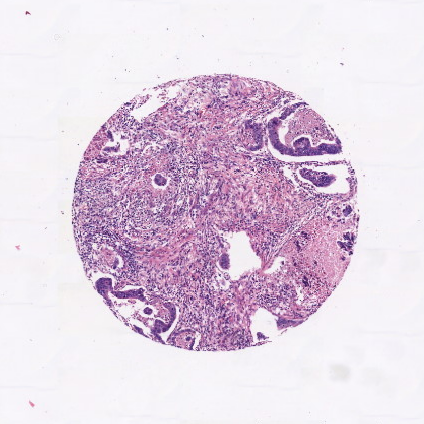

In [127]:
print(enlarged_tile)
Spot.get_tile(Spot, *(enlarged_tile), path=r.path, tif_name = r.tif_fn)

In [17]:

#dff = process_tma(tmas[2], level=3)
#dff

In [18]:
ds.patient_ID = ds.patient_ID.astype(str) #Patient ID should be converted to str as both ints and str are mixed

In [19]:
ds.patient_ID.nunique()

922

In [20]:
ds.patient_ID = ds.patient_ID.astype('object')
print(ds.patient_ID.dtype)

object


In [21]:
ds.iloc[0]

tile          [13100, 4100, (300, 300), 4]
path          DTS2019                     
tif_fn        TMA06-03                    
patient_ID    1173                        
label         62.72                       
Name: 0, dtype: object

In [22]:
ds.tif_fn.unique()

array(['TMA06-03', 'TMA06-04', 'TMA06-05', 'TMA06-06', 'TMA06-07',
       'TMA06-08', 'TMA06-09', 'TMA06-10', 'TMA06-12', 'TMA06-15',
       'TMA08-15', 'TMA08-16', 'TMA08-17', 'TMA08-18', 'TMA08-33',
       'TMA08-34', 'TMA08-36', 'TMA08-37', 'TMA08-38', 'TMA08-46',
       'TMA08-68', 'TMA08-70', 'TMA08-72', 'TMA09-22', 'TMA09-37',
       'TMA09-46', 'TMA14-04', 'TMA14-06', 'TMA06-11', 'TMA08-35 (2)',
       'TMA20-002', 'TMA20-003', 'TMA20-004', 'TMA20-005', 'TMA20-006'],
      dtype=object)

In [23]:
#change label by choosing other field from df_label
d = ds.merge(df_labels, how='left', left_on='patient_ID',right_on='COD_DTS', )
d = d.loc[d['Epicolon1+2IHQ-IMS-maria paper lynlike_IMS'].isna() == False]
d.label = d['Epicolon1+2IHQ-IMS-maria paper lynlike_IMS'].apply(lambda x: x)
d.label = True
d.loc[d['Epicolon1+2IHQ-IMS-maria paper lynlike_IMS'] == "inestable",'label' ] = False

In [24]:
d.label.describe()

count     2004
unique    2   
top       True
freq      1922
Name: label, dtype: object

In [25]:
d.label.unique()

array([ True, False])

In [26]:
# number of tiles in dataset 
d.shape[0]

2004

In [27]:
#generate training and validation partition avoiding patient overlap
# First: order dataset by patient ID
d.sort_values(['patient_ID'], inplace = True)
d.reset_index(drop=True, inplace=True)
# Second: assign 75% training and 30% validation from ordered dataset 
cut = int(0.75 * d.shape[0])
sep = d.iloc[cut]
cut = d.loc[d.patient_ID == sep.patient_ID].index[0]  #include all tiles of the the current patient in validation set


#idxs = np.random.permutation(range(d.shape[0]))
#train_files = d.iloc[idxs[:cut]]
#valid_files = d.iloc[idxs[cut:]]
train_files = d.iloc[:cut]
print(train_files.label.describe())
valid_files = d.iloc[cut:]
valid_files.label.describe()

count     1503
unique    2   
top       True
freq      1475
Name: label, dtype: object


count     501 
unique    2   
top       True
freq      447 
Name: label, dtype: object

In [28]:
train_files.iloc[13]

tile                                          [47500, 20600, (300, 300), 4]
path                                          DTS2019                      
tif_fn                                        TMA14-06                     
patient_ID                                    06-11839-5                   
label                                         True                         
COD_DTS                                       06-11839-5                   
Epicolon1+2IHQ-IMS-maria paper lynlike_IMS    estable                      
LynchIMS                                      esporadico                   
ihq_mlh1                                      positiu                      
dukes_r                                       I                            
TNMagrup                                      I                            
BaseEP1y2actualizada2016-OSCAR-def_n          0                            
grado_di                                      bien, mod                    
infirec     

In [29]:
def get_x(r,rotate=False,flip=False):
    img = Spot.get_tile(Spot, *(r.tile), path=r.path, tif_name = r.tif_fn, degrees = 360*np.random.random() if rotate else 0.)
    t = torch.Tensor(np.array(img)[...,:3])
    if flip:
        a = np.random.randint(4,dtype=np.uint8)
        if a > 0: t = t.flip(dims=np.where(np.unpackbits(a,bitorder='l'))[0].tolist())
    t = t.permute(2,0,1).float()/255.0
    return TensorImage(t)

def get_y(r): return  torch.Tensor([r.label.astype(bool)]).long()

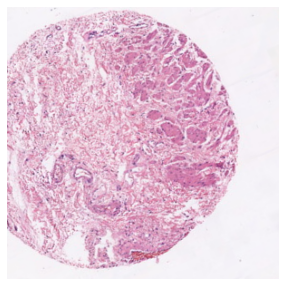

In [33]:
get_x(ds.iloc[2],True,True).show()

In [34]:
train_ds = Datasets(train_files,[partial(get_x,rotate=True,flip=False),get_y])
valid_ds = Datasets(valid_files,[get_x,get_y])

In [35]:
from fastai2.data.core import DataLoaders

In [36]:
from sklearn.utils.class_weight import compute_class_weight
labels = train_files.label.astype(int).values
w = compute_class_weight('balanced',np.unique(labels), labels)
wgts = w[labels]
train_dl = WeightedDL(train_ds,wgts=wgts,shuffle=True,bs=128*2,after_batch=[Normalize.from_stats(*imagenet_stats),])
valid_dl = WeightedDL(valid_ds,wgts=None,bs=128,after_batch=[Normalize.from_stats(*imagenet_stats),])

In [37]:
dls = DataLoaders(train_dl, valid_dl, device=default_device(), )

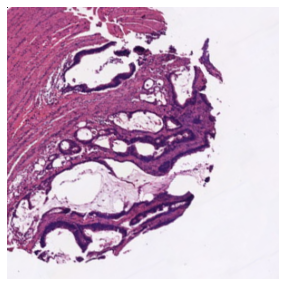

In [38]:
train_ds[1][0].show()


In [39]:
b = dls[0].one_batch()
#len(b[0])
b[0][0]

tensor([[[1.9064, 1.9064, 1.9235,  ..., 1.8893, 1.8550, 1.8893],
         [1.9064, 1.9064, 1.9235,  ..., 1.8722, 1.8550, 1.8550],
         [1.9064, 1.9064, 1.9064,  ..., 1.8722, 1.8722, 1.8722],
         ...,
         [1.9235, 1.9064, 1.9064,  ..., 1.9064, 1.9064, 1.9064],
         [1.9064, 1.9064, 1.9064,  ..., 1.9064, 1.9064, 1.9064],
         [1.9064, 1.9064, 1.9064,  ..., 1.9064, 1.9064, 1.9064]],

        [[2.0609, 2.0609, 2.0784,  ..., 2.0434, 2.0084, 2.0434],
         [2.0609, 2.0609, 2.0784,  ..., 2.0259, 2.0084, 2.0084],
         [2.0609, 2.0609, 2.0784,  ..., 2.0259, 2.0259, 2.0259],
         ...,
         [2.0784, 2.0609, 2.0609,  ..., 2.0609, 2.0609, 2.0609],
         [2.0609, 2.0609, 2.0609,  ..., 2.0609, 2.0609, 2.0609],
         [2.0609, 2.0609, 2.0609,  ..., 2.0609, 2.0609, 2.0609]],

        [[2.3786, 2.3786, 2.3960,  ..., 2.3611, 2.3263, 2.3611],
         [2.3786, 2.3786, 2.3786,  ..., 2.3437, 2.3263, 2.3263],
         [2.3786, 2.3786, 2.3786,  ..., 2.3437, 2.3437, 2.

AttributeError: 'Tensor' object has no attribute 'show'

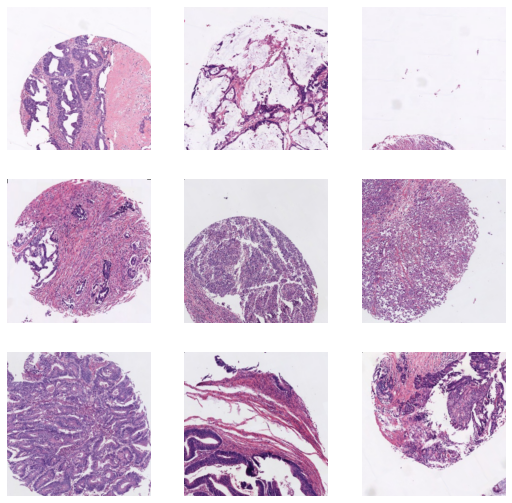

In [40]:
dls[0].show_batch()

In [41]:
learn = cnn_learner(dls, resnet34,
                    config={'ps':0, 'custom_head' : nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512 ,2))}, 
                    loss_func=CrossEntropyLossFlat(), normalize=False, metrics=accuracy ,n_out=2)
learn.to_parallel().to_fp16()
learn.unfreeze()

In [42]:
learn.summary()

Sequential (Input shape: ['256 x 3 x 300 x 300'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               256 x 64 x 150 x 15  9,408      True      
________________________________________________________________
BatchNorm2d          256 x 64 x 150 x 15  128        True      
________________________________________________________________
ReLU                 256 x 64 x 150 x 15  0          False     
________________________________________________________________
MaxPool2d            256 x 64 x 75 x 75   0          False     
________________________________________________________________
Conv2d               256 x 64 x 75 x 75   36,864     True      
________________________________________________________________
BatchNorm2d          256 x 64 x 75 x 75   128        True      
________________________________________________________________
ReLU                 256 x 64 x 75 x 75   0          False     
________________________________________________

SuggestedLRs(lr_min=0.13182567358016967, lr_steep=1.0964782238006592)

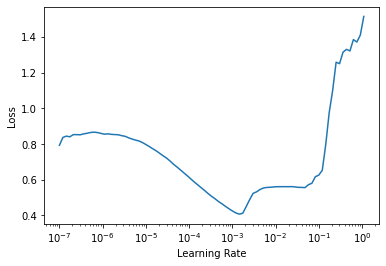

In [43]:
learn.lr_find()

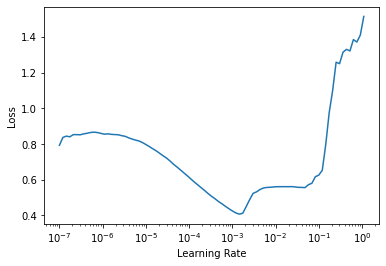

In [44]:
learn.recorder.plot_lr_find()

In [45]:
learn.fit_one_cycle(2,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.928320,1.400998,0.892216,00:32
1,0.664988,1.322242,0.449102,00:31


In [2]:
interp = Interpretation.from_learner(learn)

NameError: name 'Interpretation' is not defined

In [47]:
preds = learn.get_preds()

In [48]:
preds

(tensor([[0.9211, 0.0789],
         [0.8984, 0.1016],
         [0.9471, 0.0529],
         ...,
         [0.0483, 0.9517],
         [0.8269, 0.1731],
         [0.8104, 0.1896]]),
 tensor([[1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [0],
         [0],
         [1],
         [1],
         [0],
         [0],
         [0],
         [0],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [0],
         [0],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [

In [1]:
(preds[0] <= 0.5).sum()

NameError: name 'preds' is not defined

In [ ]:
(preds[1] <= 0.5).sum()

In [ ]:
p = (preds[0] > 0.5).long();p

In [ ]:
accuracy(p,preds[1])

In [ ]:
((preds[0] > 0.5) == (preds[1] == 1)).sum().float()/preds[0].numel()

In [ ]:
interp = Interpretation.from_learner(learn)

In [ ]:
interp.__dict__


In [ ]:
interp.losses.shape

In [ ]:
tma = tmas[1]

print(tma.meta_path)
print(tma.img_path_tif)

print(tma.spots[2].center)
spot = tma.spots[5]
jpg = spot.load_img_jpg()
tif = tma.load_img_tif()
tif

In [ ]:
tma.img_tif.properties
print(spot.TMA.name)
print(spot.name)
print(spot.ID)
print(spot.diameter)
spot.get_center_pixel()
print(spot.get_radious_pixel(0))
print(spot.get_circle_coordinates_pixel(0))
print(spot.check_tile_in_spot(41100, spot.get_circle_coordinates_pixel(0)[1] - spot.get_radious_pixel(0)[0]))
spot.get_tile(41100, spot.get_circle_coordinates_pixel(0)[1] - spot.get_radious_pixel(0)[0])

In [ ]:
img = spot.get_enclosing_box(4)
print(img.size)
img

In [ ]:
spot.tiles = []
print(len(spot.tiles))
for t in spot.sample_tiles(size = (300,300), level = 2, overlap = .3):
    print(t)
    

In [ ]:
print(len(spot.tiles))
print(spot.tiles[1])

In [ ]:
plt.imshow(spot.get_tile(*spot.tiles[0]))

In [ ]:
spot.get_tile(*spot.tiles[0])

In [ ]:
tma.img_tif.properties